In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
import scipy.ndimage as ndimage

In [2]:
rcParams['savefig.dpi'] = 300
rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'Lucida Bright'
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Interpreting data

### Eastbourne lines

In [3]:
eastbourne = np.array([[14876.49305556, 21312.26851852],
       [15834.375     , 22177.11419753],
       [16440.38194444, 23041.95987654],
       [17183.22916667, 23968.58024691],
       [18121.5625    , 24617.21450617],
       [18923.05555556, 24987.86265432],
       [19196.73611111, 25605.6095679 ],
       [19685.45138889, 26594.00462963],
       [19255.38194444, 26964.65277778],
       [19001.25      , 27335.30092593],
       [18492.98611111, 27520.625     ],
       [17280.97222222, 27675.0617284 ],
       [16596.77083333, 28663.45679012],
       [14720.10416667, 29281.2037037 ],
       [13390.79861111, 29559.18981481],
       [12608.85416667, 29898.95061728],
       [12256.97916667, 29126.76697531],
       [12022.39583333, 27953.04783951],
       [12862.98611111, 27211.75154321],
       [13390.79861111, 26655.77932099],
       [12980.27777778, 25667.38425926],
       [13605.83333333, 25451.17283951],
       [12980.27777778, 24709.87654321],
       [13253.95833333, 24030.35493827],
       [13273.50694444, 23381.72067901],
       [13801.31944444, 22825.74845679],
       [14720.10416667, 23041.95987654],
       [14720.10416667, 22547.76234568],
       [13508.09027778, 21991.79012346],
       [14114.09722222, 21343.1558642 ],
       [14876.49305556, 21312.26851852]])

### Read data

In [127]:
scenario = 0
# work_path = "../../../Schenarios/Scenario_"+str(scenario+1)+"_alt/SWAN/Output/"
work_path = "../../../Schenarios/Scenario_"+str(scenario+1)+"/SWAN/Output/"
project_name = "Eastbourne_01"

head = (pd.read_csv(work_path+project_name+"_f1.tab",sep='\s+',skiprows=4)).columns[1:]
df = pd.read_csv(work_path+project_name+"_f1.tab",sep='\s+',skiprows=7, names= head)

C:\Users\ianmu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Define variables to be loaded

In [128]:
Vars = "Xp", "Yp", "Hsig", "Depth", "Wlen", "Watlev", "PkDir", "Dissip", "Sfric", "Ssurf", "Swcap", "Sswell"
empties = "self", "self", -9, -9, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
empty_value_of_third_var = -9
# Xp and Yp stay first place and second respectively

### Convert all data types and replace empty values

In [129]:
data_list = []
for i in range(len(Vars)):
    data_list.append(np.array(df[Vars[i]],dtype=float))
    if (empties[i] != "self"):
        for j in range(len(data_list[i])):
            if(data_list[2][j] == empty_value_of_third_var or np.isnan(data_list[2][j])):
                data_list[i][j] = empties[i]

### Put all data in matrixes

In [130]:
lenx = np.sum(data_list[0][0] == data_list[0])
leny = int(len(data_list[0]) / lenx)

mat_list = []
for i in range(len(Vars)-2):
    mat_list.append(np.zeros([int(lenx), int(leny)]))
    for j in range(lenx):
        mat_list[i][len(mat_list[i]) -1 - j] = data_list[i+2][int(leny*j):int(leny*(j+1))]

# General Plotting script

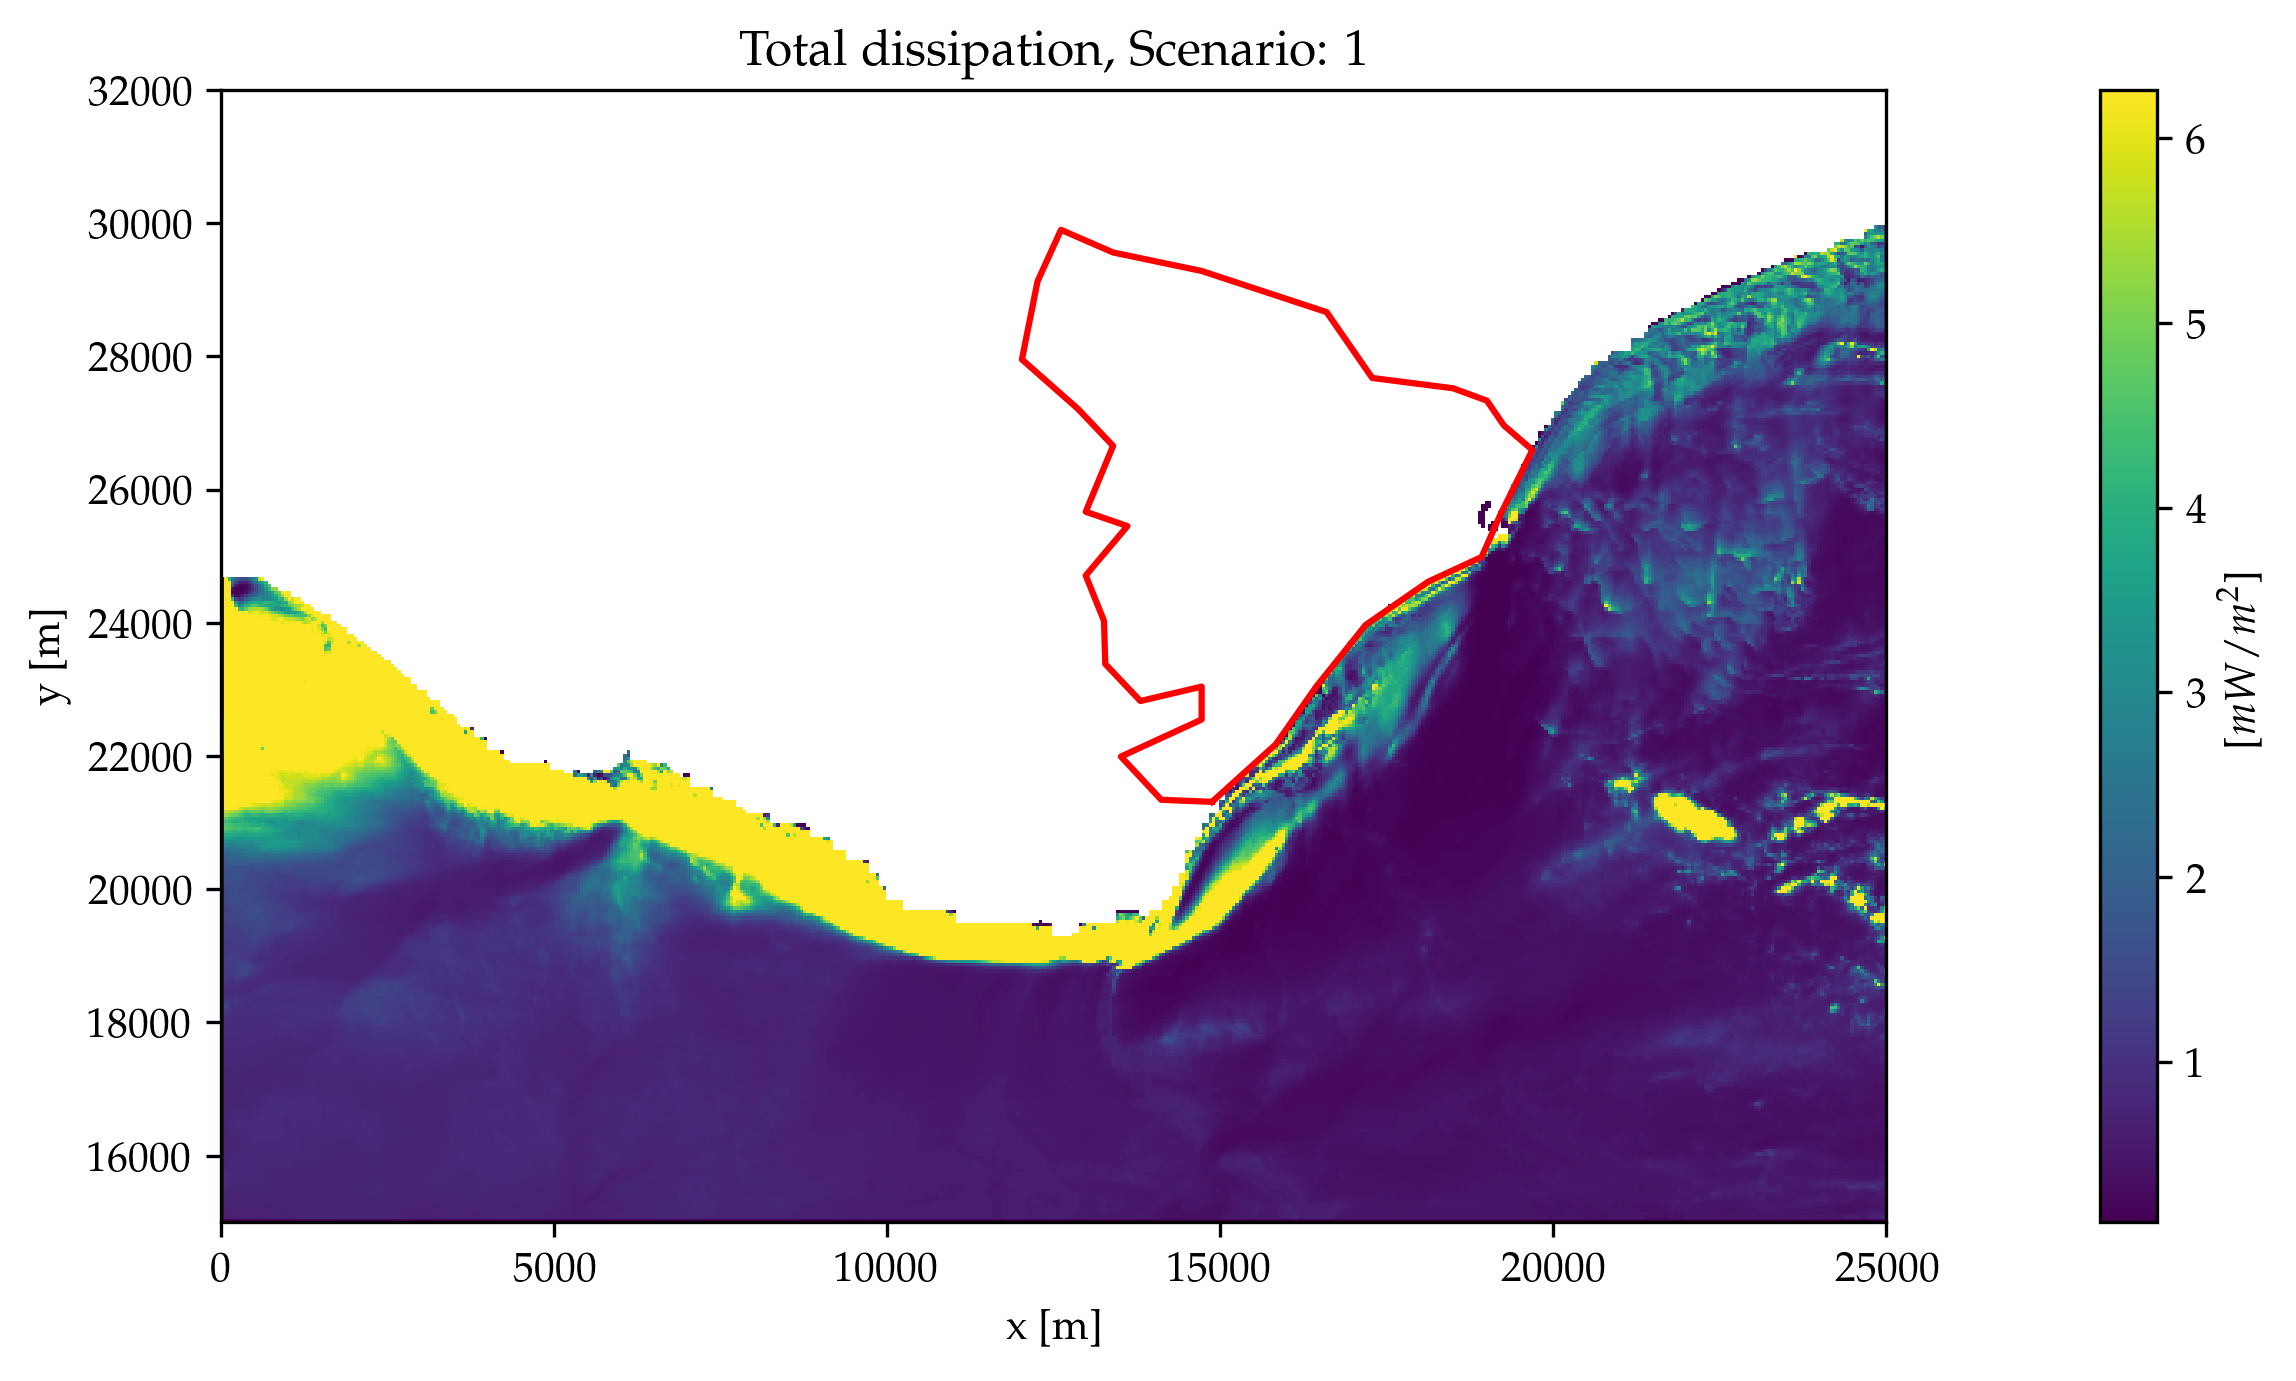

In [131]:
plot_var = "Dissip"
#"Dissip", "Sfric", "Ssurf", "Swcap", "Sswell"
title = "Total dissipation"
unit = "[$mW/m^2$]"
#title = "Surf breaking induced dissipation"
cmap = None # bwr

# Read lengths

# find index plot var
for i in range(len(Vars)):
    if (Vars[i] == plot_var):
        index = i - 2
        break
    if (i == len(Vars) - 1):
        title = "!!! Wrong parameter name, thus old plot is loaded !!!"

top_cut = 0
        
plt.figure(figsize = [10,5])
plt.title(title + ", Scenario: " +str(scenario+1))
plt.imshow(mat_list[index][top_cut:]*1000, extent = [data_list[0][0] , data_list[0][-1], data_list[1][0], data_list[1][-leny*top_cut-1]],cmap=cmap,
          vmax= 6.26,vmin= np.nanpercentile(mat_list[5][top_cut:]*1000,1))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
cbar = plt.colorbar()
cbar.set_label(unit)
plt.axis('scaled')
plt.plot(eastbourne[:,0],eastbourne[:,1],'r')

# Wave breaking analyses

### Depth induced breaking

Breaking parameter via Battjes and Stive (1985) as decribed by Holthuijsen

In [132]:
# Schenarios
T = np.array([9.5016076, 9.4770921, 9.0278389, 8.6234757, 8.0506301, 6.8425639, 6.8425639, 7]) # second to last one is BS
surge = mat_list[3][-1][0]

Hm0 = mat_list[0] # if Hs is thus the 3d var in the mat
d = mat_list[1]
Hrms = Hm0/2

gamma_mat_list = []
for i in range(len(T)):
    Lp0 = 9.81*T[i]**2/(2*np.pi)
    s0 = Hrms/Lp0
    gamma = 0.5 + 0.4*np.tanh(33*s0)
    gamma_mat_list.append(gamma)

### $\gamma$ plot

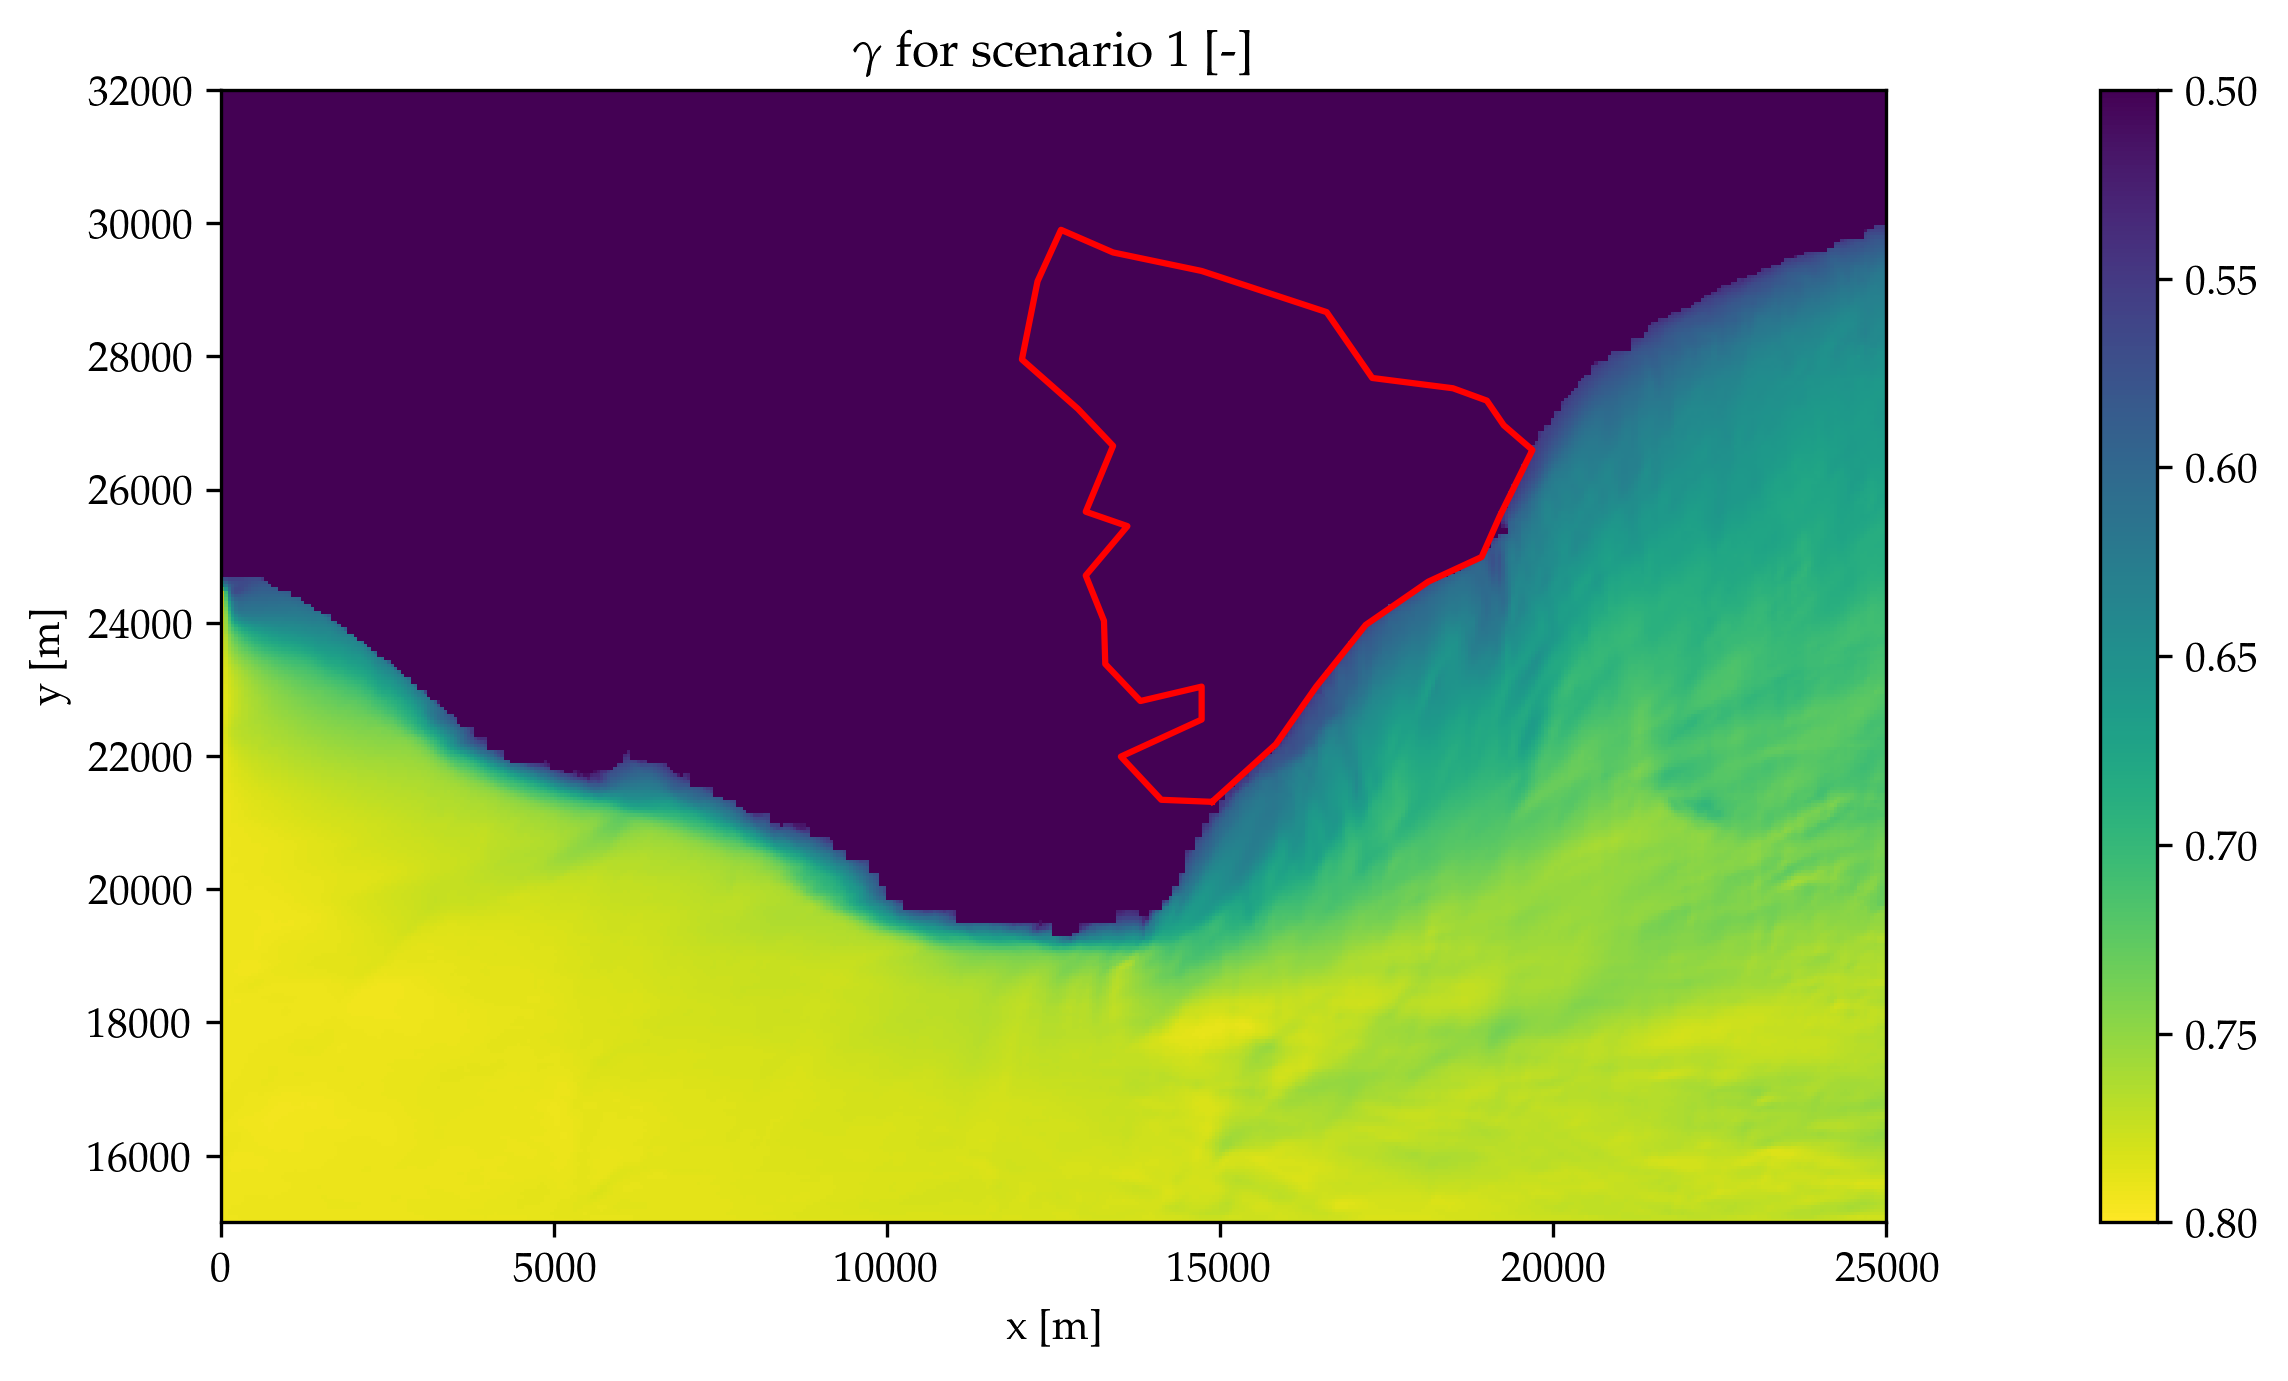

In [133]:
title = "$\gamma$ for scenario " + str(scenario+1)
unit = "[-]"
cmap = None

# Read lengths

plt.figure(figsize = [10,5])
plt.title(title +" "+ unit)
plt.imshow(gamma_mat_list[scenario][top_cut:], cmap = cmap, extent = [data_list[0][0] , data_list[0][-1], data_list[1][0], data_list[1][-leny*top_cut-1]],
          vmin=0.5,vmax=0.8)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
cbar = plt.colorbar()
cbar.ax.invert_yaxis()
plt.axis('scaled')
plt.plot(eastbourne[:,0],eastbourne[:,1],'r')

### $\frac{H_{m0}}{\gamma(\zeta+d)}$ plot

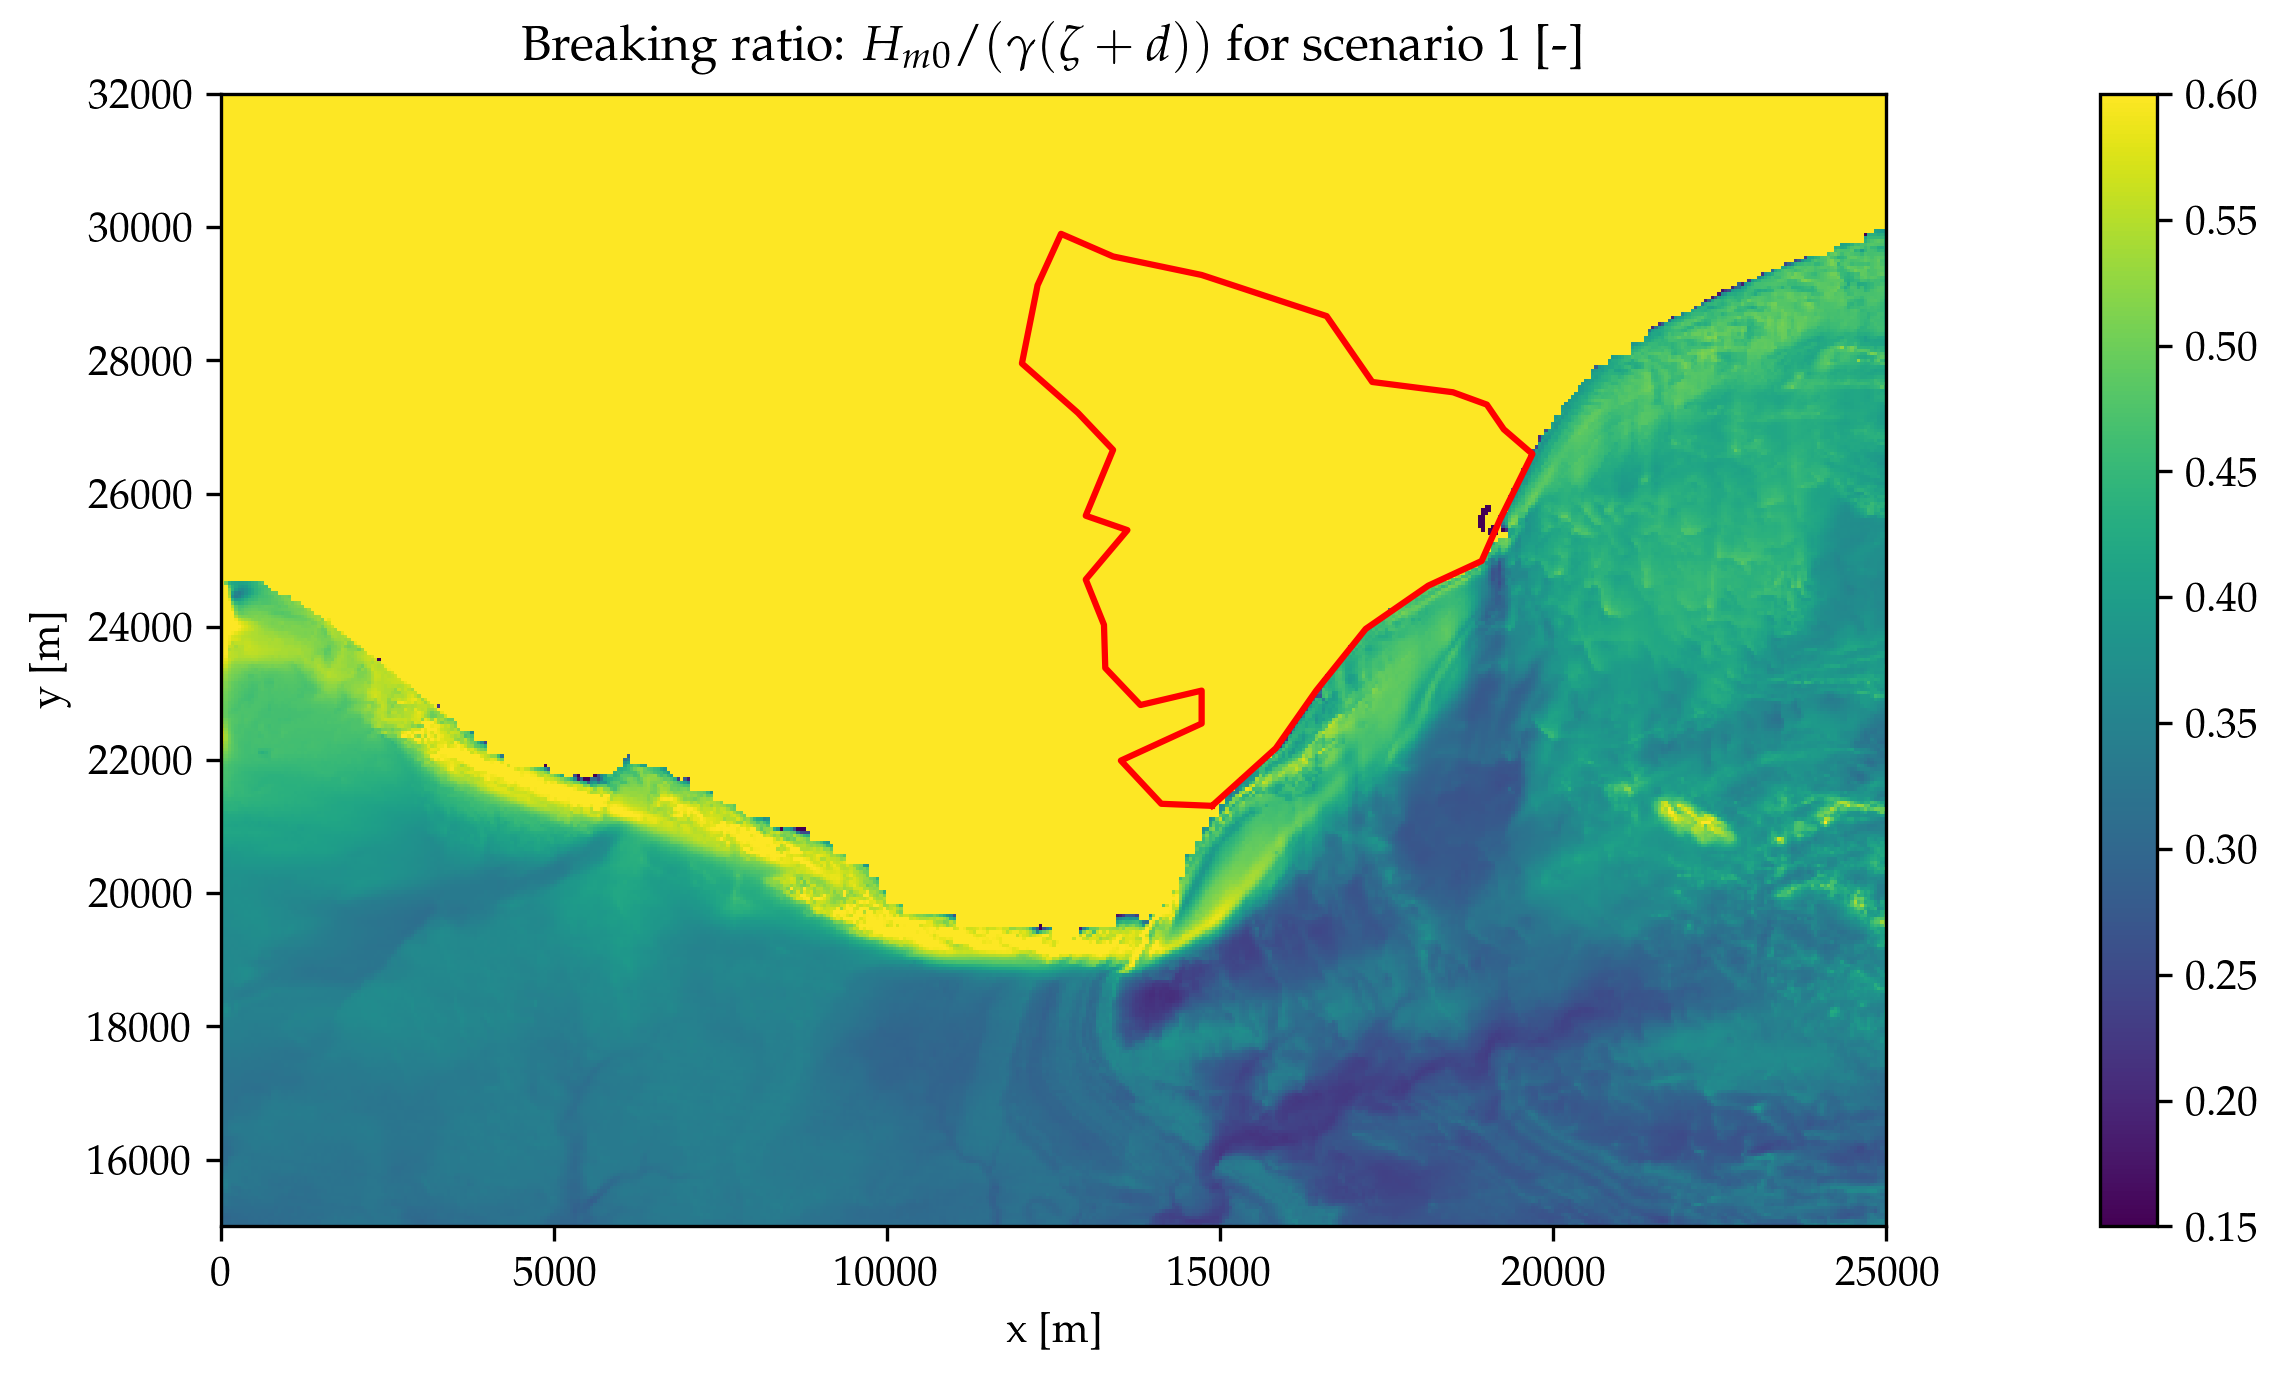

In [134]:
breaking_rat = Hm0 / (gamma_mat_list[scenario] * (surge + d))
cmap = None
title = "Breaking ratio: $H_{m0}/(\gamma(\zeta+d))$ for scenario " + str(scenario+1)
unit = "[-]"

# Read lengths
        
plt.figure(figsize = [10,5])
plt.title(title +" "+ unit)
plt.imshow(breaking_rat[top_cut:], extent = [data_list[0][0] , data_list[0][-1], data_list[1][0], data_list[1][-leny*top_cut-1]], cmap = cmap,
          vmin = 0.15, vmax = 0.6)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.axis('scaled')
plt.plot(eastbourne[:,0],eastbourne[:,1],'r')

### Steepness induced breaking

Miche 1944

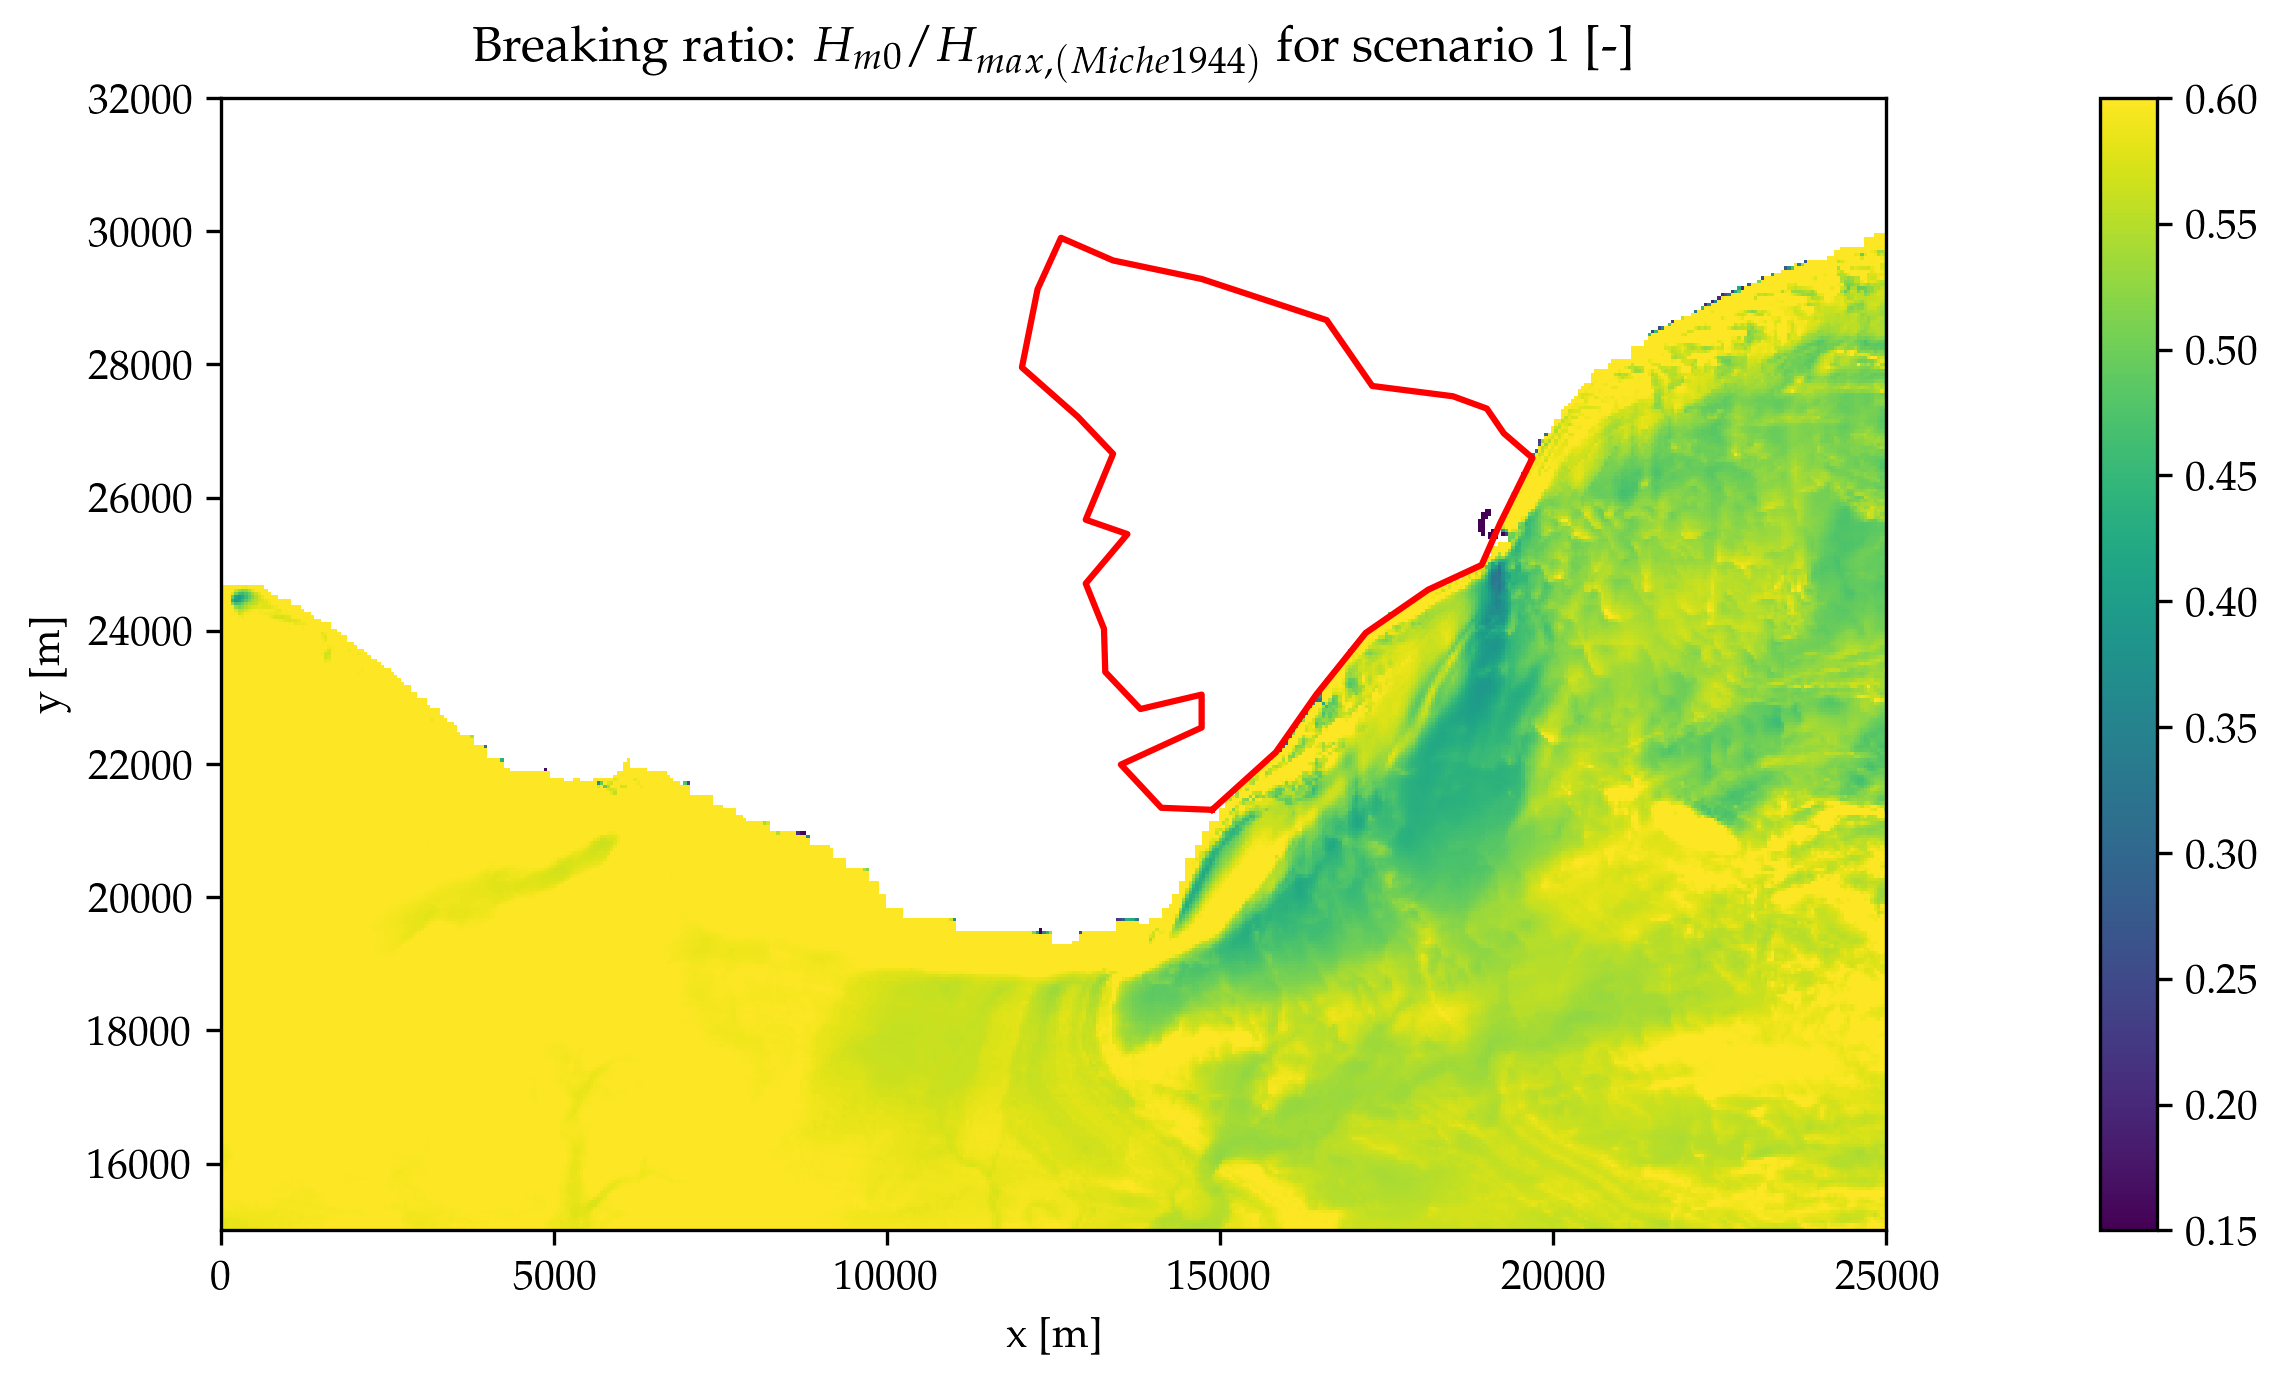

In [135]:
L = mat_list[2]
H_max = 0.14*mat_list[2]*np.tanh(2*np.pi*d/L)
title = "Breaking ratio: $H_{m0}/H_{max,(Miche 1944)}$ for scenario " + str(scenario+1)
unit = "[-]"

plt.figure(figsize = [10,5])
plt.title(title +" "+ unit)
plt.imshow(Hm0/H_max[top_cut:], extent = [data_list[0][0] , data_list[0][-1], data_list[1][0], data_list[1][-leny*top_cut-1]], cmap = cmap,
          vmin = 0.15, vmax = 0.6)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.axis('scaled')
plt.plot(eastbourne[:,0],eastbourne[:,1],'r')

# Shore normal plot

C:\Users\ianmu\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


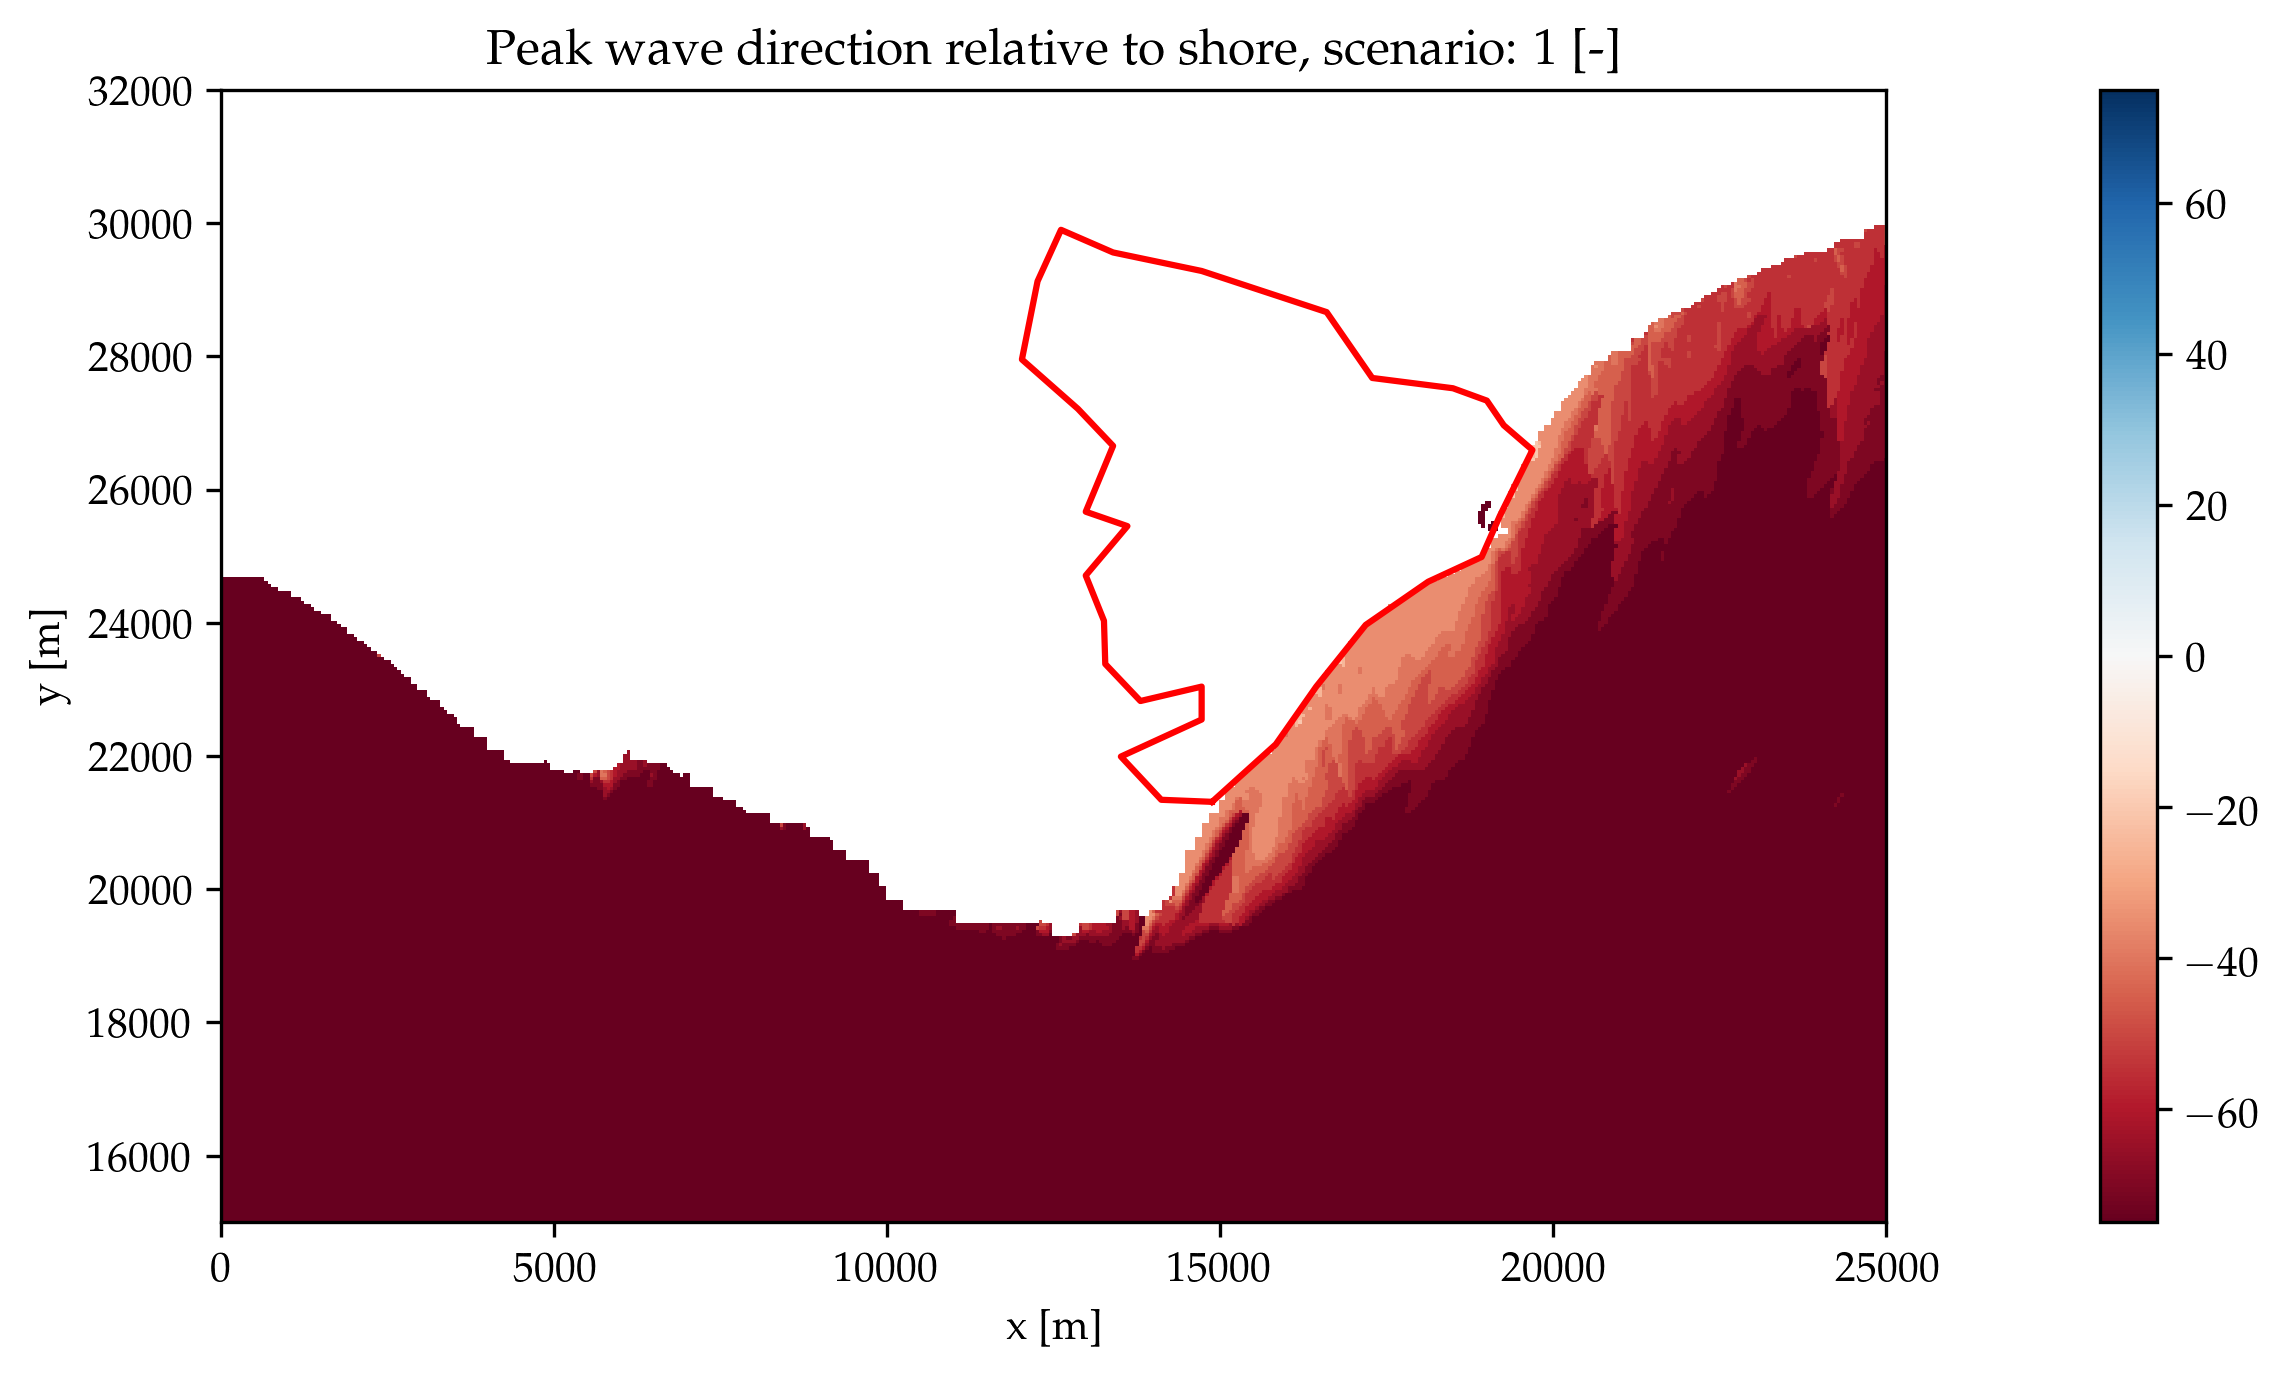

In [184]:
title = "Peak wave direction relative to shore, scenario: " + str(scenario+1)
unit = "[-]"
cmap = "RdBu"

shore_norm_dir = 140 # deg

pdir = mat_list[4]
pdir_shift = pdir - shore_norm_dir
pdir_shift[pdir_shift>180] = pdir_shift[pdir_shift>180] -360
# Read lengths
        
plt.figure(figsize = [10,5])
plt.title(title +" "+ unit)
plt.imshow(pdir_shift[top_cut:], cmap = cmap, extent = [data_list[0][0] , data_list[0][-1], data_list[1][0], data_list[1][-leny*top_cut-1]],
          vmax= 75, vmin=-75)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.axis('scaled')
plt.plot(eastbourne[:,0],eastbourne[:,1],'r')

# 1D cross section conversion

Using 3d order spline

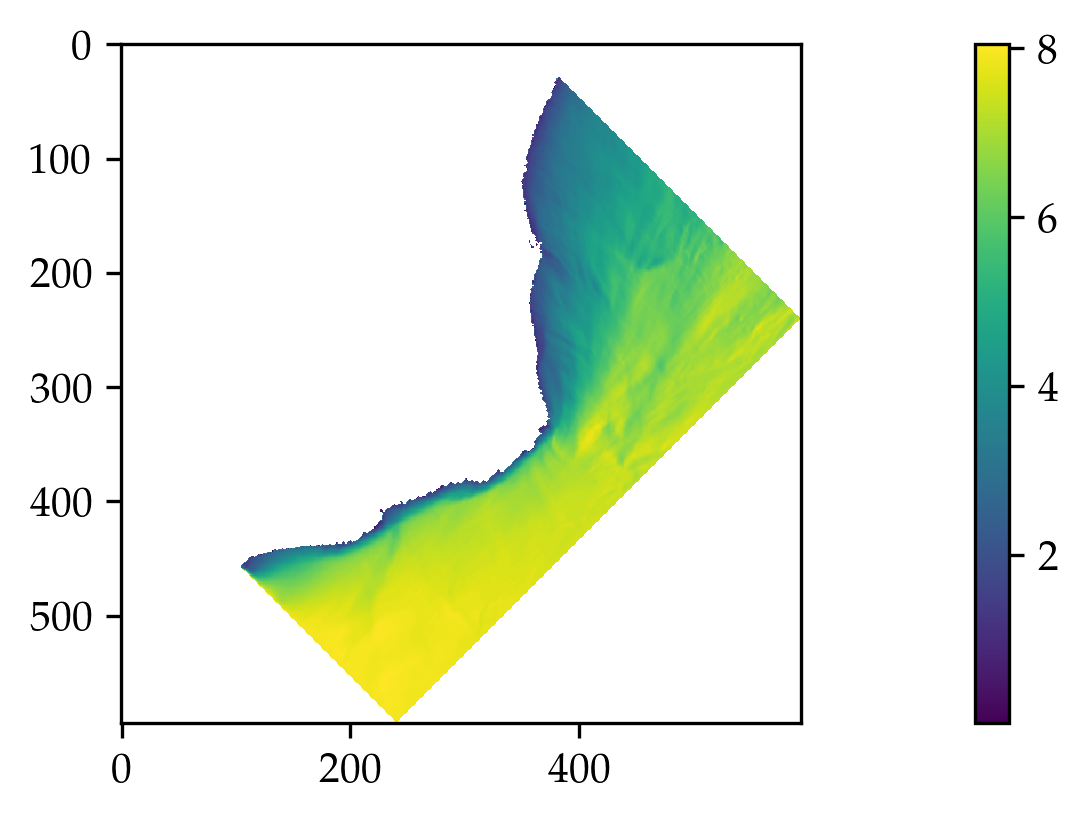

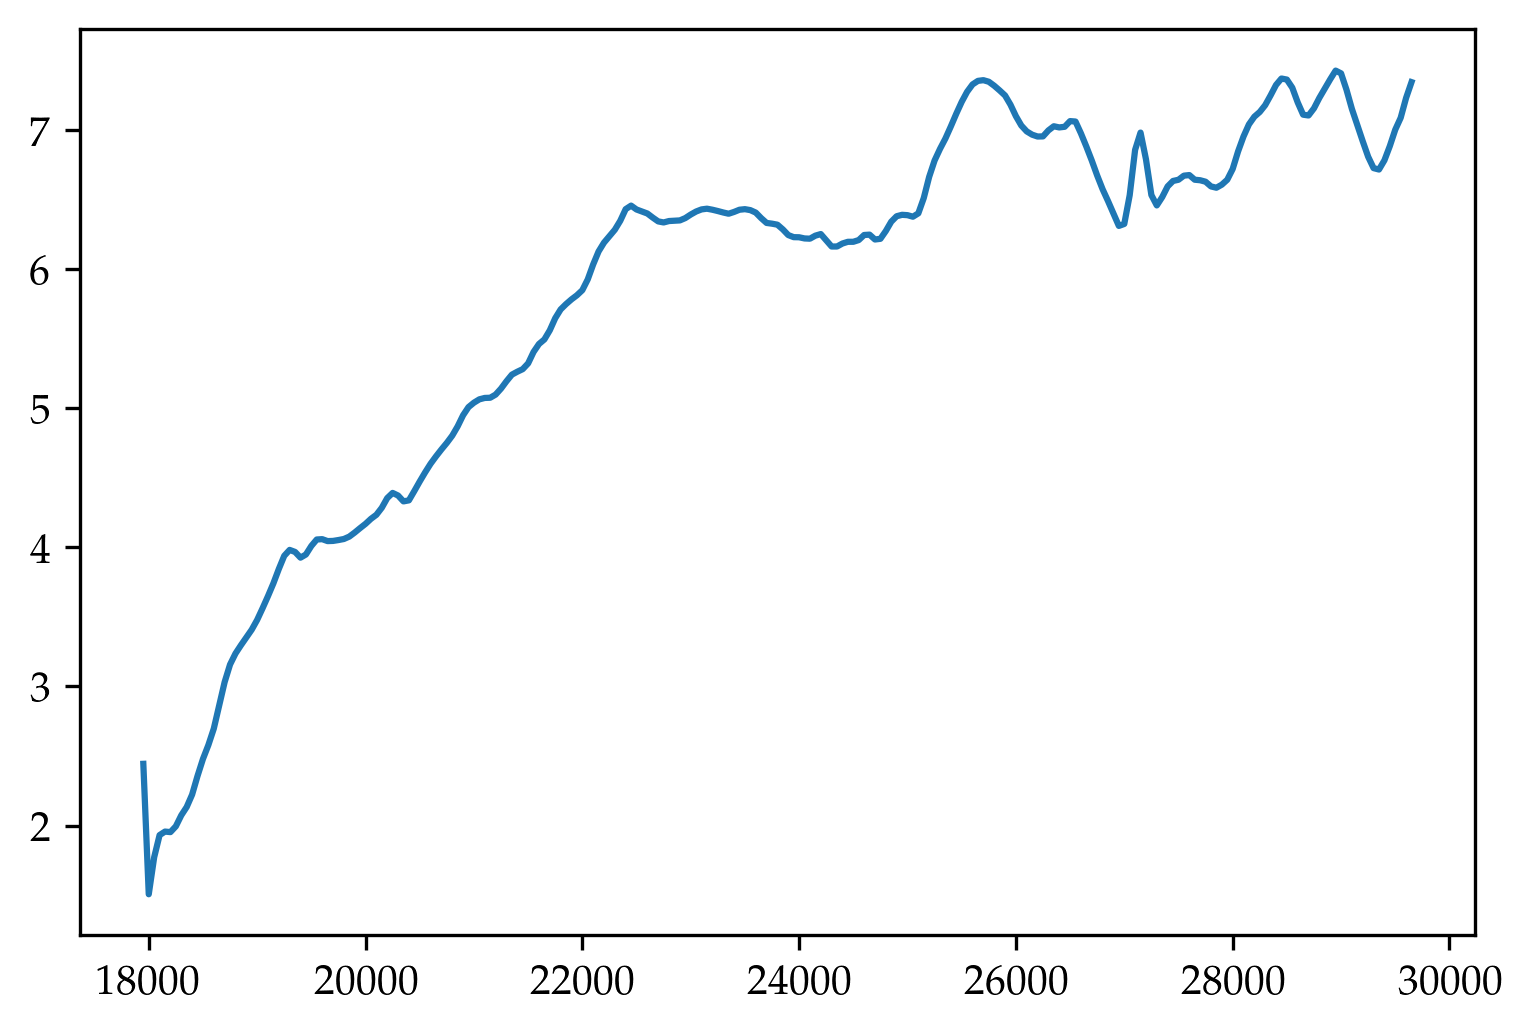

In [188]:
angles = 45, 60, 27
loc = 0
cross_var = Hm0

mat_rot = ndimage.rotate(cross_var,angles[loc],cval=-99)
mat_rot_lens = len(mat_rot),len(mat_rot[0])
mat_rot[mat_rot<0] = np.nan

plt.figure(figsize=[15,3])
plt.imshow(np.reshape(mat_rot,(mat_rot_lens[0],mat_rot_lens[1])))
plt.colorbar()

plt.figure()
plt.plot(np.arange(len(mat_rot[240]))*50, mat_rot[240])

In [170]:
mat_rot_lens

(595, 595)

In [150]:
len(mat_rot)

595